In [17]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix)
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
# 数据路径配置
TRAIN_PATH = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Train/Africa_train_1.csv"
TEST_PATH = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/Africa_test_1.csv"
TEST_PATH1 = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/Asia_test_1.csv"
TEST_PATH2 = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/Europe_test_1.csv"
TEST_PATH3 = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/North_test_1.csv"
TEST_PATH4 = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/South_test_1.csv"
TEST_PATH5 = "/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Test/Oceania_test_1.csv"

# 数据加载函数
def load_data(path):
    df = pd.read_csv(path)
    X = df.iloc[:, :22].values
    y = df.iloc[:, 24].values
    feature_names = df.columns[:22].tolist()
    return X, y, feature_names

# 加载训练数据
X, y, feature_names = load_data(TRAIN_PATH)
print(f"数据样本量: {X.shape[0]}")
print(f"类别分布:\n{pd.Series(y).value_counts()}")

# 初始数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

数据样本量: 6420
类别分布:
1    3210
0    3210
Name: count, dtype: int64


In [19]:
# XGBoost参数配置（针对小样本优化）
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,          # 限制树深度防止过拟合
    'eta': 0.1,              # 学习率
    'subsample': 0.8,        # 样本采样比例
    'colsample_bytree': 0.8, # 特征采样比例
    'lambda': 1.5,           # L2正则化
    'alpha': 0.5,            # L1正则化
    'min_child_weight': 2,   # 防止小样本过拟合
    'seed': 42
}

# 5折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_metrics = []
fold = 1

for train_idx, val_idx in kfold.split(X_train, y_train):
    # 数据集划分
    X_trn, X_val = X_train[train_idx], X_train[val_idx]
    y_trn, y_val = y_train[train_idx], y_train[val_idx]
    
    # 转换为DMatrix格式
    dtrain = xgb.DMatrix(X_trn, label=y_trn, feature_names=feature_names)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
    
    # 模型训练
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=100,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )
    
    # 验证集预测
    y_pred = model.predict(dval)
    y_pred_bin = (y_pred >= 0.5).astype(int)
    
    # 计算指标
    metrics = {
        'Fold': fold,
        'Accuracy': accuracy_score(y_val, y_pred_bin),
        'Precision': precision_score(y_val, y_pred_bin),
        'Recall': recall_score(y_val, y_pred_bin),
        'F1': f1_score(y_val, y_pred_bin),
        'AUC': roc_auc_score(y_val, y_pred)
    }
    cv_metrics.append(metrics)
    
    # 打印当前fold结果
    print(f"Fold {fold}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f} | AUC: {metrics['AUC']:.4f} | Precision: {metrics['Precision']:.4f} | Recall: {metrics['Recall']:.4f} | F1: {metrics['F1']:.4f}" )
    fold += 1

# 计算平均指标
avg_metrics = pd.DataFrame(cv_metrics).mean(numeric_only=True)
print("\nCross Validation Average Metrics:")
print(avg_metrics.to_string())

# 全量训练集训练最终模型
dtrain_all = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
final_model = xgb.train(
    params,
    dtrain_all,
    num_boost_round=1000,
    evals=[(dtrain_all, "train")],
    verbose_eval=False
)

Fold 1:
Accuracy: 0.9933 | AUC: 0.9997 | Precision: 0.9978 | Recall: 0.9889 | F1: 0.9933
Fold 2:
Accuracy: 0.9922 | AUC: 0.9995 | Precision: 0.9933 | Recall: 0.9911 | F1: 0.9922
Fold 3:
Accuracy: 0.9900 | AUC: 0.9998 | Precision: 0.9955 | Recall: 0.9844 | F1: 0.9899
Fold 4:
Accuracy: 0.9944 | AUC: 0.9997 | Precision: 0.9933 | Recall: 0.9956 | F1: 0.9945
Fold 5:
Accuracy: 0.9967 | AUC: 1.0000 | Precision: 0.9956 | Recall: 0.9978 | F1: 0.9967

Cross Validation Average Metrics:
Fold         3.000000
Accuracy     0.993325
Precision    0.995093
Recall       0.991546
F1           0.993309
AUC          0.999736


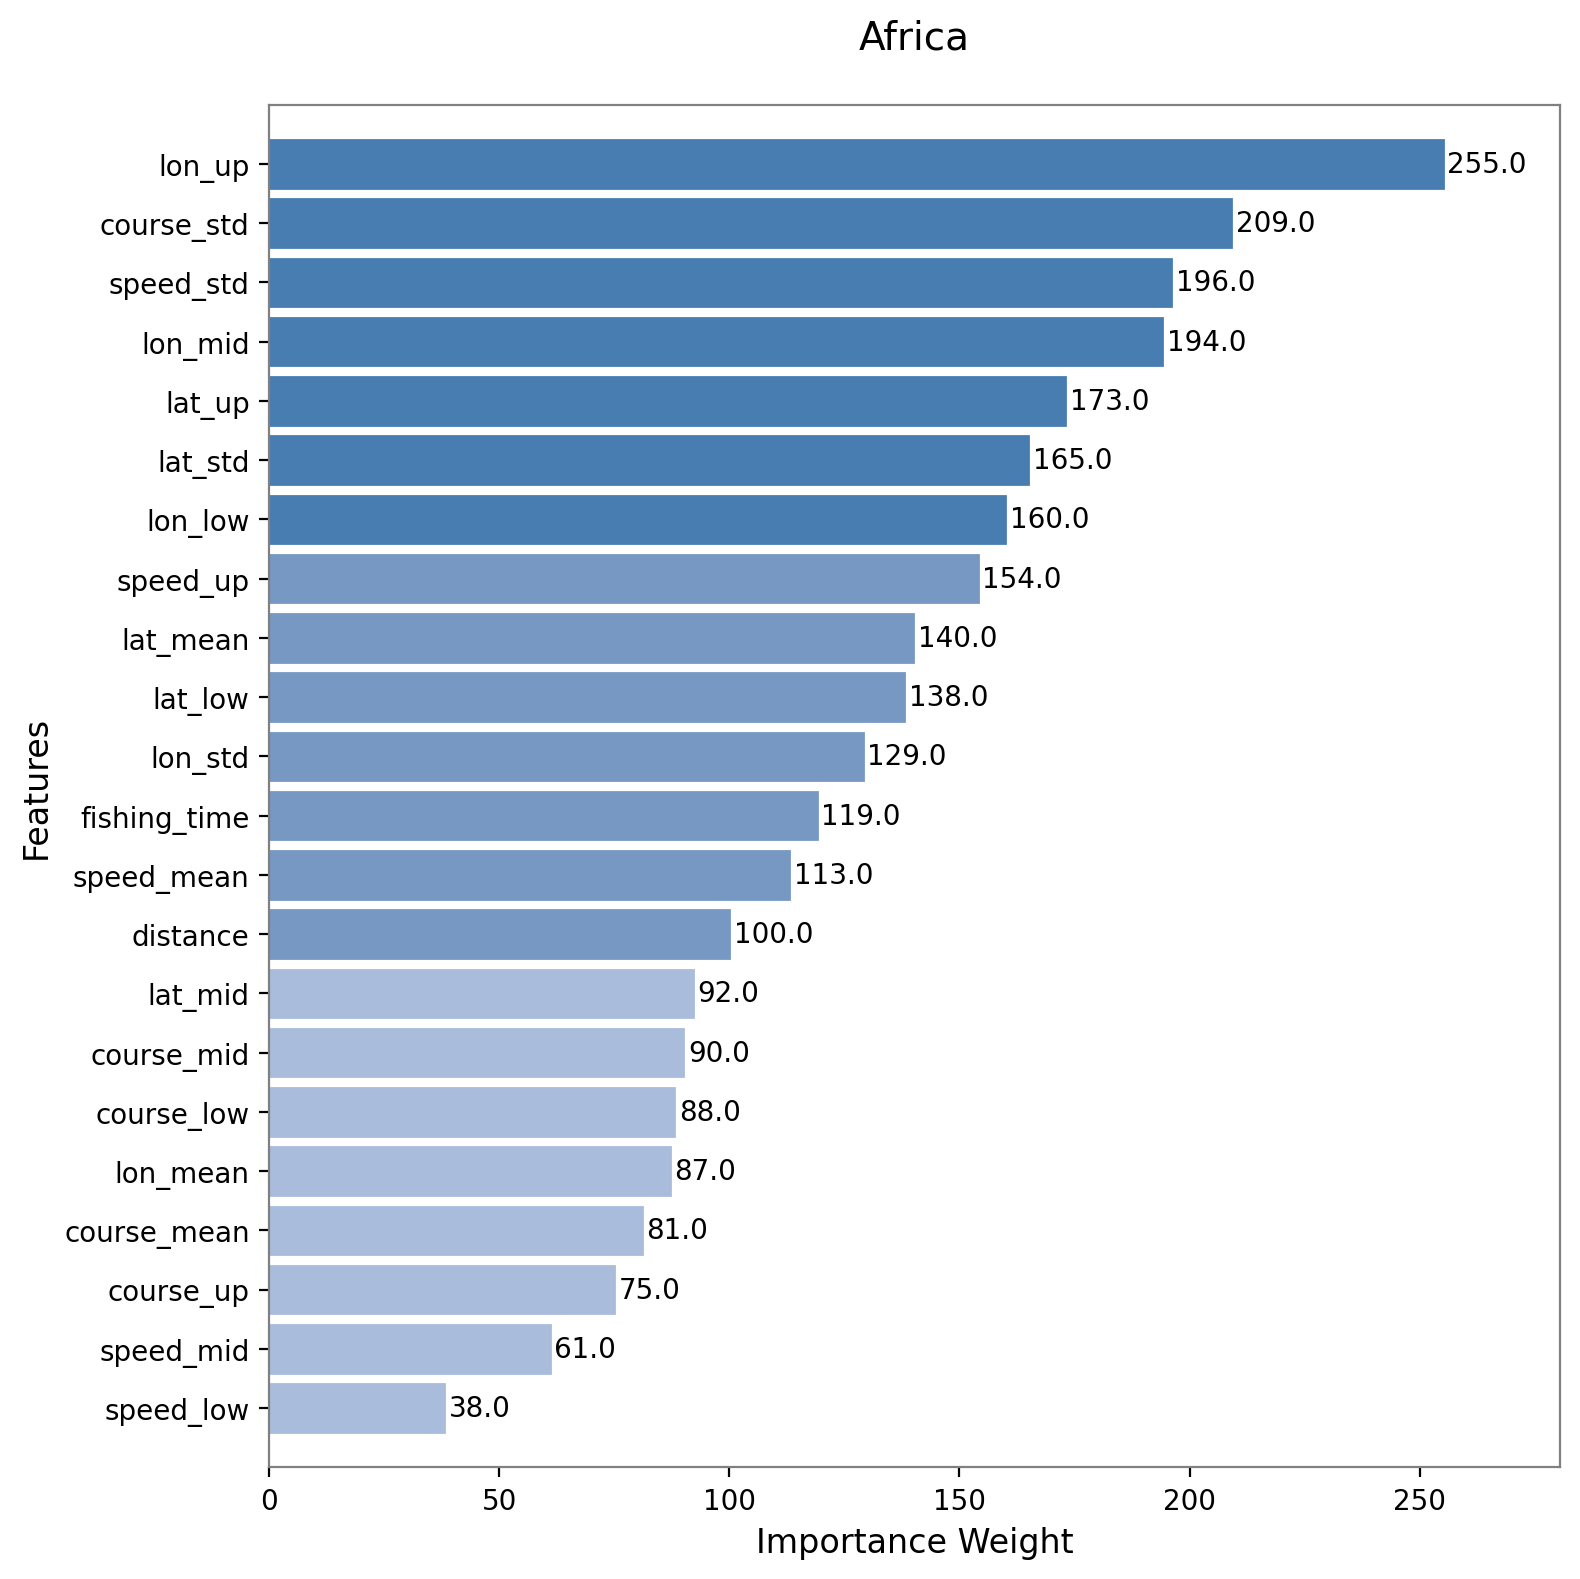

In [20]:
# # 设置全局显示参数
plt.rcParams['figure.dpi'] = 200  # 基础DPI设置
plt.rcParams['figure.figsize'] = [8, 8]  # 默认显示尺寸

# # 在Jupyter中启用Retina显示（需在开头单元格运行）
# %config InlineBackend.figure_format = 'retina'

# # 特征重要性可视化（优化显示版）
# fig, ax = plt.subplots(figsize=(18, 12), dpi=200)  # 独立设置当前画布

# # 特征重要性可视化
#plt.figure(figsize=(12, 8), dpi=500)
ax = xgb.plot_importance(
    final_model, 
    max_num_features=22,
    importance_type='weight',
    height=0.8,
    color=None
)

# 修正数据获取方式
importance_dict = final_model.get_score(importance_type='weight')
importance_df = (pd.DataFrame.from_dict(importance_dict, orient='index')
                 .reset_index()
                 .rename(columns={'index':'feature', 0:'importance'})
                 .sort_values('importance', ascending=True)
                 .tail(22))

# 创建颜色分段（按排名分三组）
n_features = len(importance_df)
colors = []
for i in range(n_features):
    if i < n_features//3:
        colors.append('#487DB2')  # 第三段
    elif i < 2*(n_features//3):
        colors.append('#7698C3')  # 第二段
    else:
        colors.append('#AABCDC')  # 第一段

# 重新设置条形颜色（修正索引方式）
bars = ax.containers[0]
for i, bar in enumerate(reversed(bars)):  # 重要：需反向匹配排序
    bar.set_color(colors[i])

# 样式调整
plt.grid(False)  # 移除网格线
plt.title('Africa', fontsize=14, pad=20)
plt.xlabel('Importance Weight', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 调整边框
ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.spines['left'].set_color('#808080')

plt.tight_layout()

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-Africa.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [21]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.9950
Precision: 0.9930
Recall: 0.9970
F1: 0.9950
AUC: 0.9999


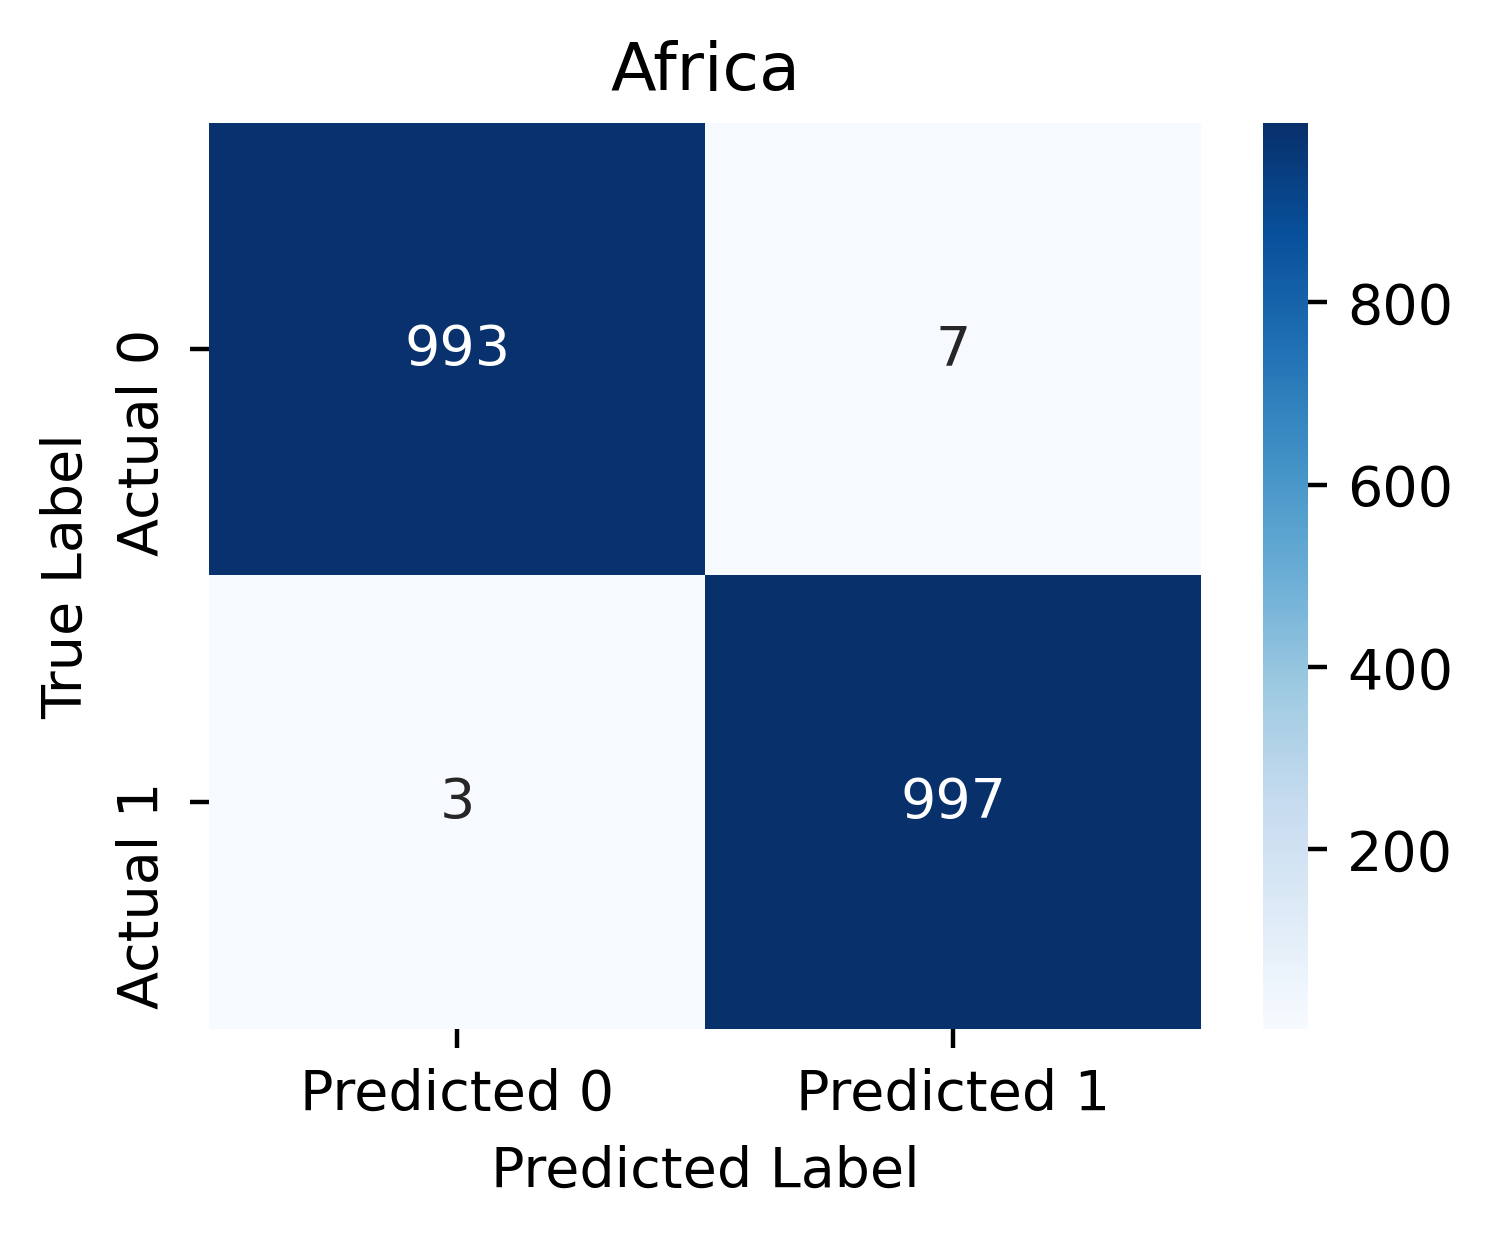

In [22]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Africa')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-1.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [23]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH1)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.5090
Precision: 0.5148
Recall: 0.3130
F1: 0.3893
AUC: 0.6609


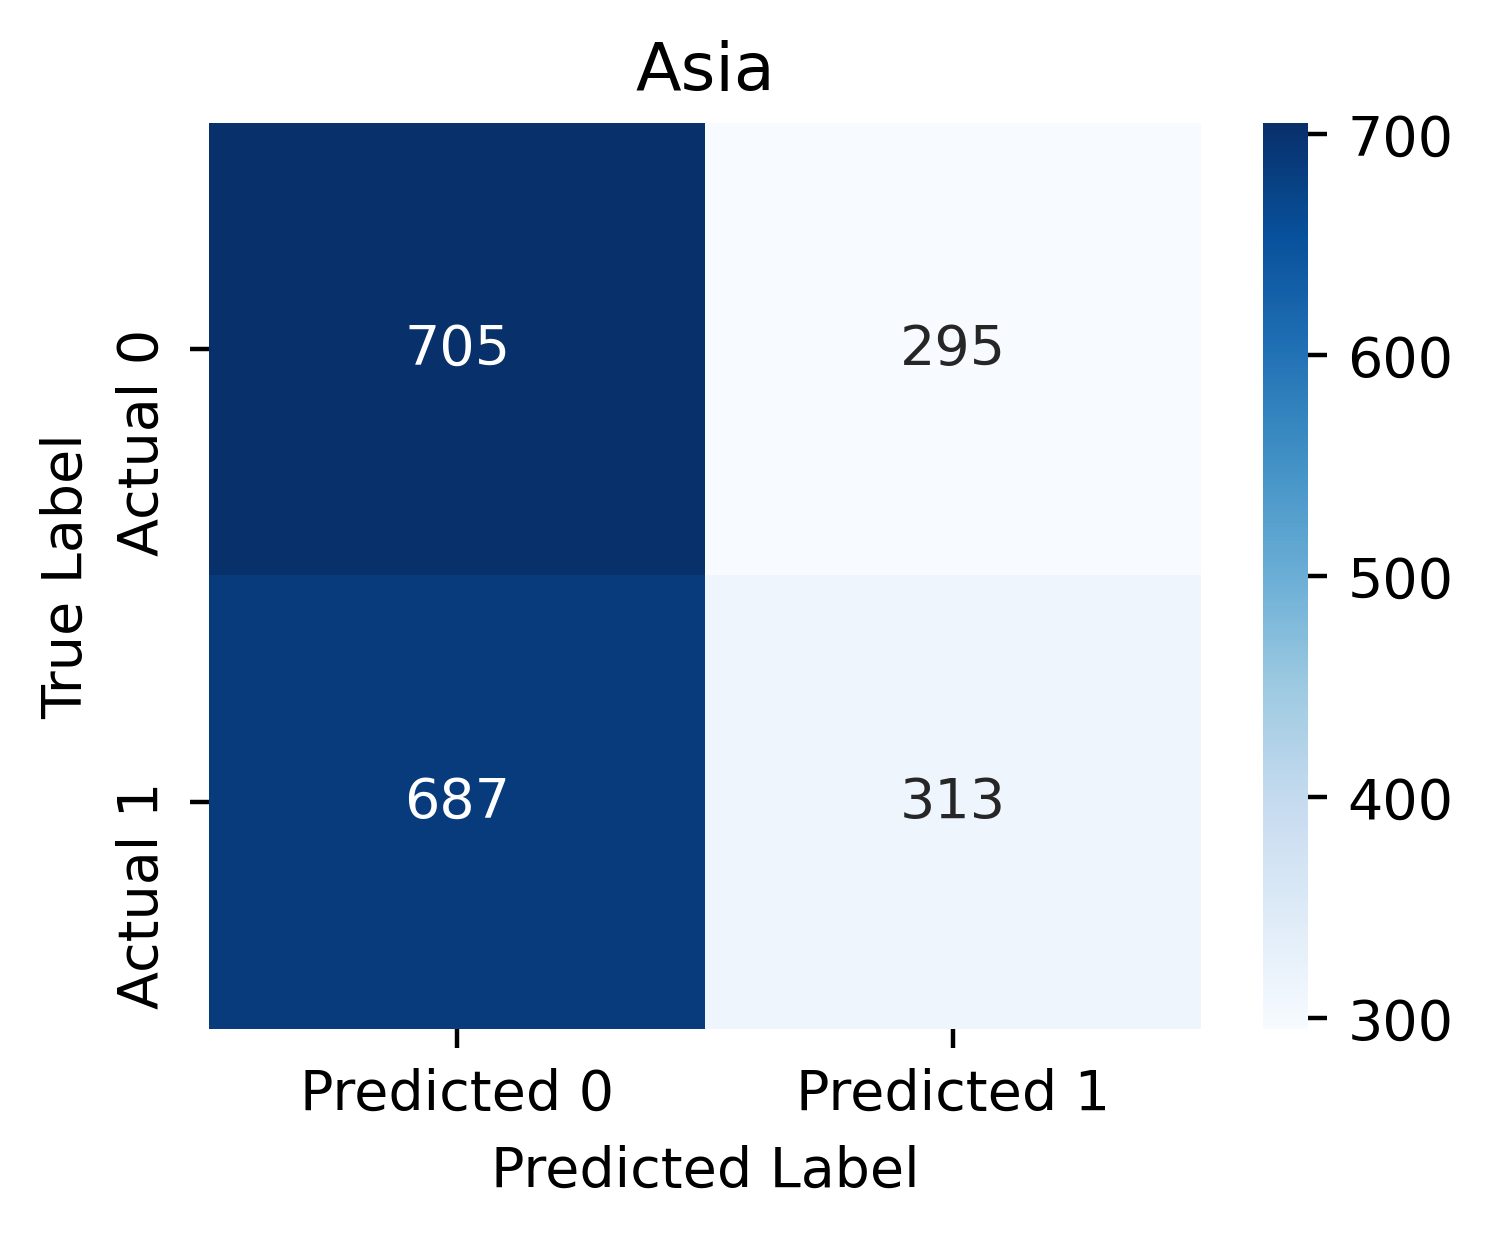

In [24]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Asia')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-2.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [25]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH2)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.6025
Precision: 0.5627
Recall: 0.9200
F1: 0.6983
AUC: 0.6498


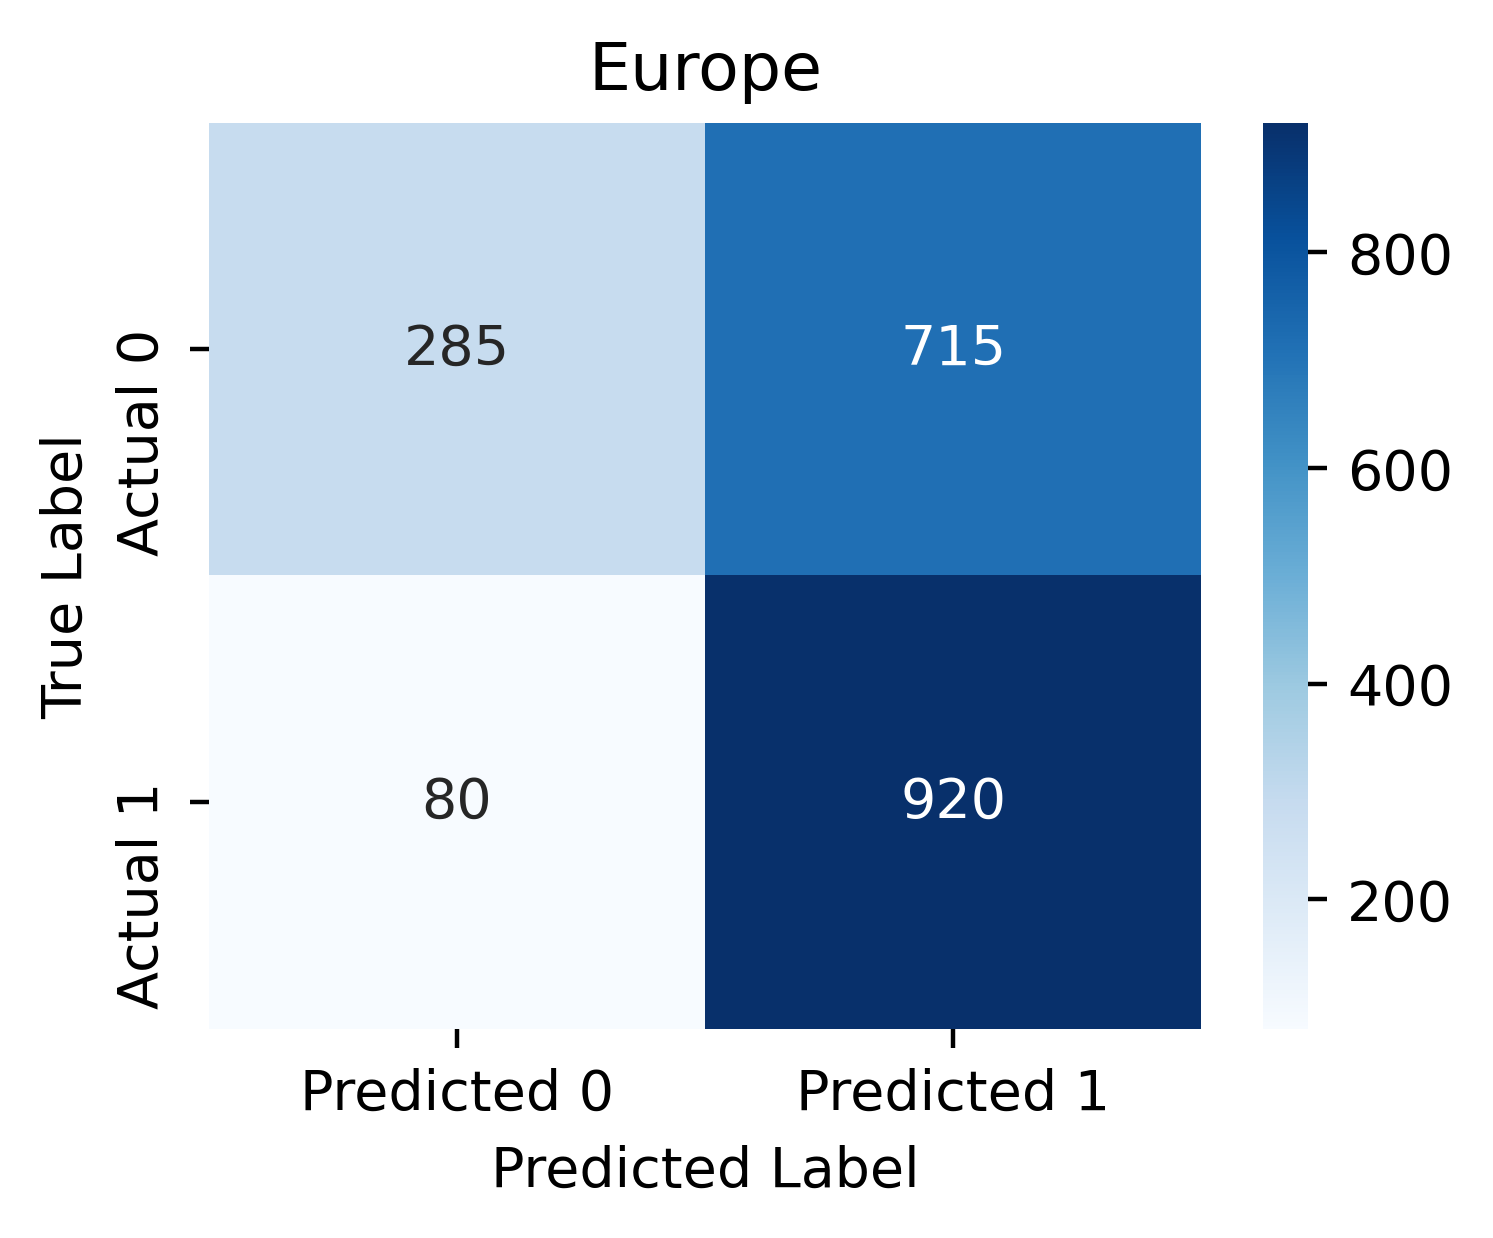

In [26]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Europe')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-3.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [27]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH3)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.4780
Precision: 0.4885
Recall: 0.9380
F1: 0.6425
AUC: 0.5718


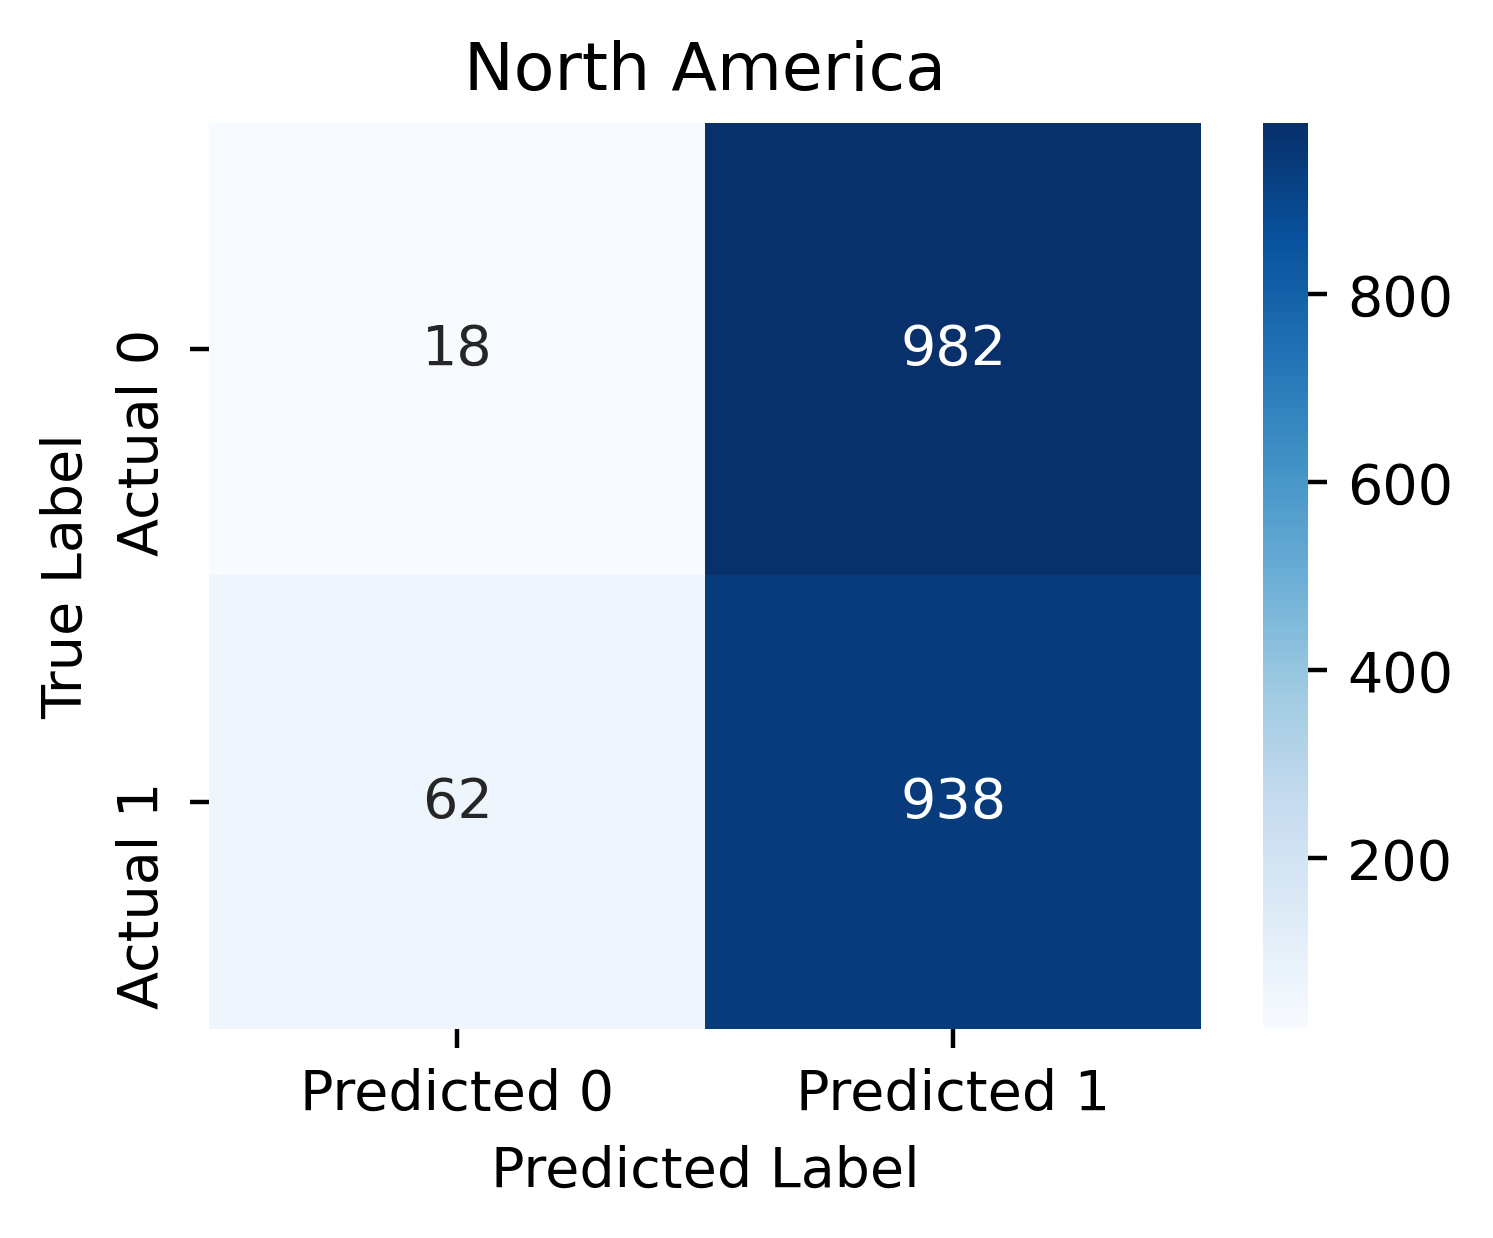

In [28]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('North America')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-4.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [29]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH4)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.5305
Precision: 0.5157
Recall: 1.0000
F1: 0.6805
AUC: 0.5828


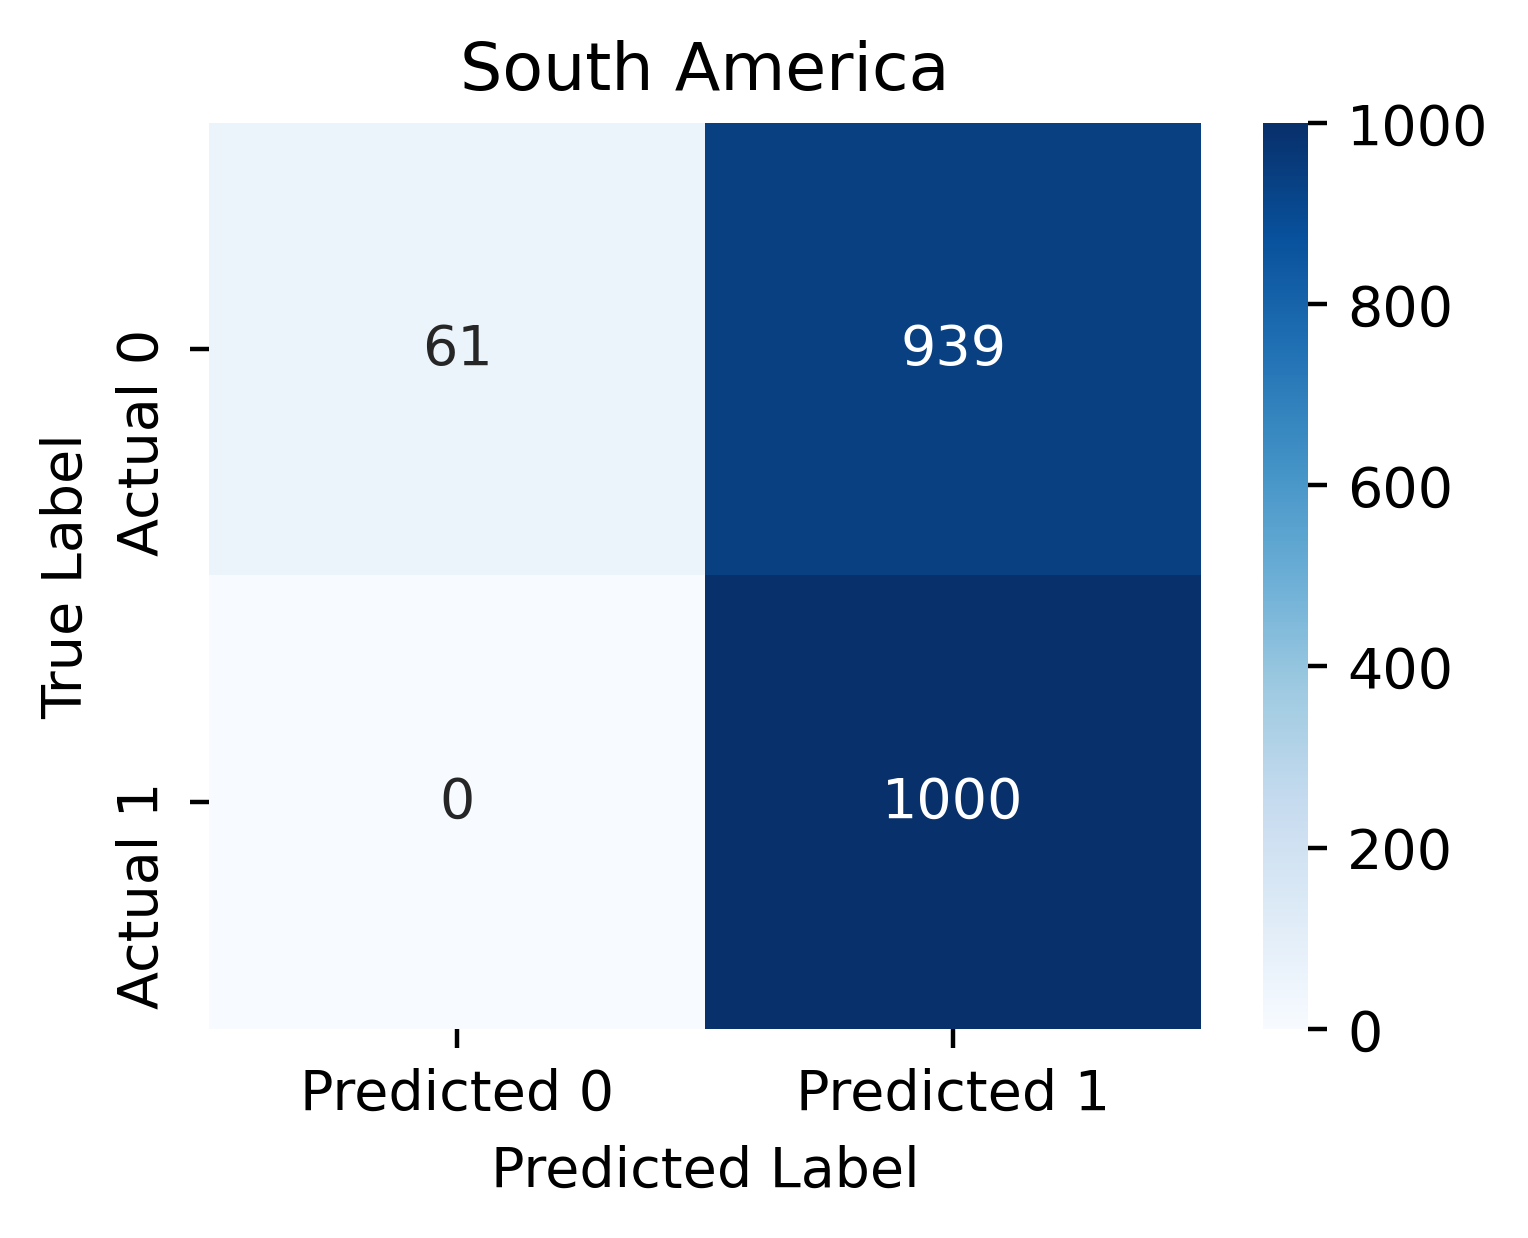

In [30]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('South America')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-5.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()

In [31]:
# 独立测试集评估
X_independent, y_independent, _ = load_data(TEST_PATH5)
dindep = xgb.DMatrix(X_independent, feature_names=feature_names)
y_indep_pred = final_model.predict(dindep)
y_indep_bin = (y_indep_pred >= 0.5).astype(int)

print("\nIndependent Test Set Performance:")
print(f"Accuracy: {accuracy_score(y_independent, y_indep_bin):.4f}")
print(f"Precision: {precision_score(y_independent, y_indep_bin):.4f}")
print(f"Recall: {recall_score(y_independent, y_indep_bin):.4f}")
print(f"F1: {f1_score(y_independent, y_indep_bin):.4f}")
print(f"AUC: {roc_auc_score(y_independent, y_indep_pred):.4f}")


Independent Test Set Performance:
Accuracy: 0.4300
Precision: 0.3849
Recall: 0.2340
F1: 0.2910
AUC: 0.5795


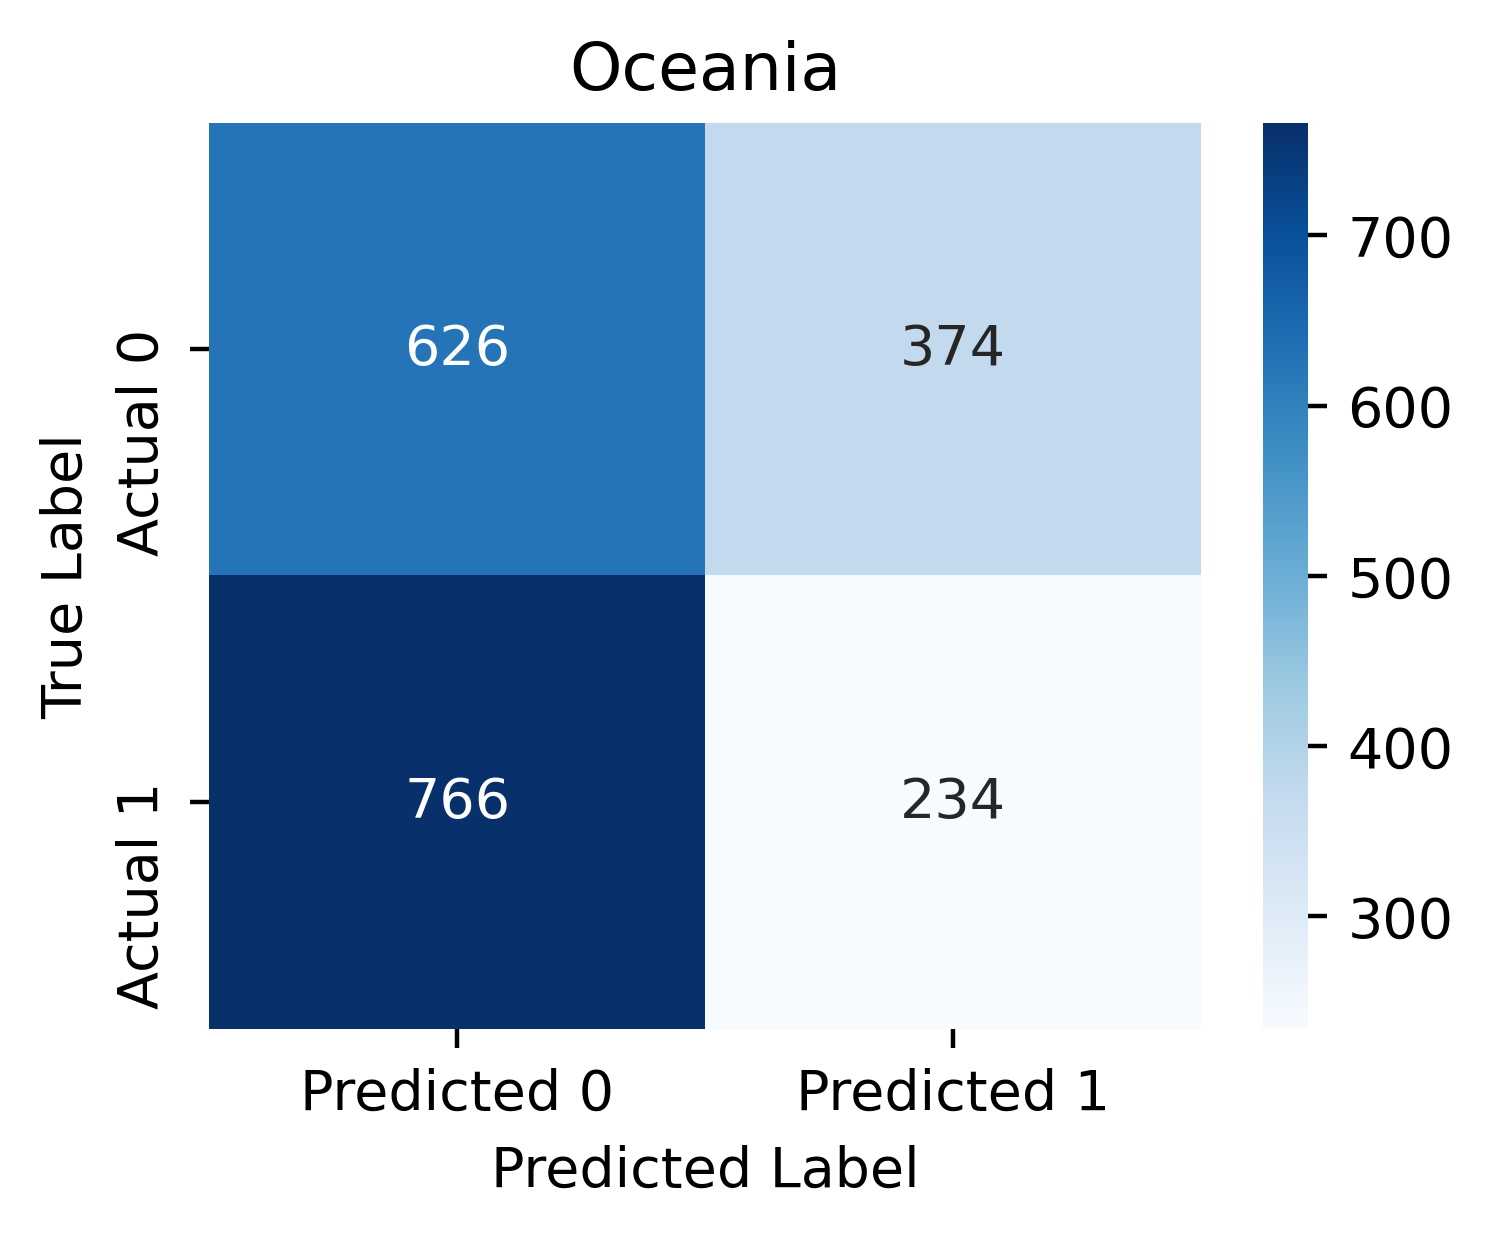

In [32]:
# 生成混淆矩阵
cm = confusion_matrix(y_independent, y_indep_bin)
plt.figure(figsize=(4, 3), dpi=400)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Oceania')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

#保存图片（需在plt.show()之前执行）
plt.savefig(
    '/cpfs01/projects-HDD/cfff-4a8d9af84f66_HDD/chengxin/Region/Figures/Africa/2-6.png',  # 保存路径（可替换为如 "/路径/文件名.png"）
    dpi=300,                   # 分辨率（继承画布设置的 dpi=200）
    bbox_inches='tight',       # 自动裁剪白边
    facecolor='white'          # 背景颜色（保持与画布一致）
)

plt.show()